In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for .pkl files output
target_dir = r"C:\Users\fredr\Documents\test_mirror\quail_volcano\scenarios\new"


# Path for Quail source code
source_dir = r"C:\Users\fredr\Documents\test_mirror\quail_volcano\src"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

Read and plot 1D

t = 0.000000 s


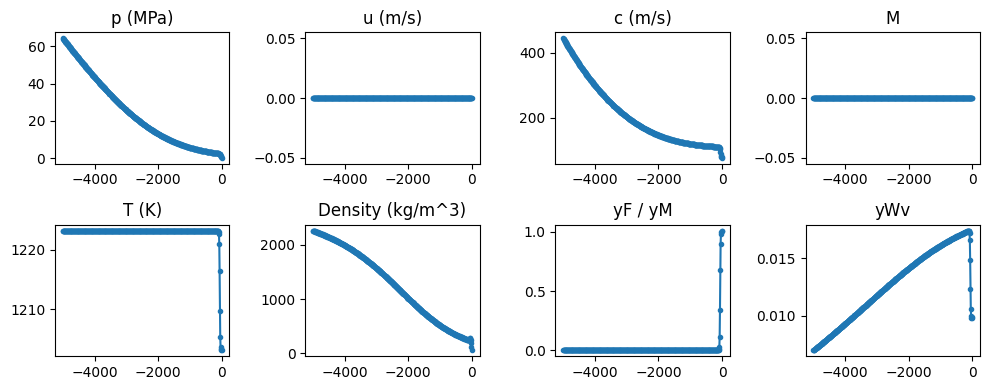

In [3]:
solver1D = readwritedatafiles.read_data_file(
  f"test_infrasound_cond_0.pkl")

physics = solver1D.physics

U = solver1D.state_coeffs
x = solver1D.elem_helpers.x_elems
p = physics.compute_variable("Pressure", U)
u = physics.compute_variable("XVelocity", U)
c = physics.compute_variable("SoundSpeed", U)
T = physics.compute_variable("Temperature", U)
rho = U[...,0:3].sum(axis=-1, keepdims=True)
yF = U[...,7:8] / rho
yA = U[...,0:1] / rho
yWv = U[...,1:2] / rho
yM = U[...,2:3] / rho


# Make a bunch of plots

fig, axes = plt.subplots(2, 4, figsize=(10,4))

quant_list = [
  ("p (MPa)", p/1e6),
  ("u (m/s)", u),
  ("c (m/s)", c),
  ("M", u/c),
  ("T (K)", T),
  ("Density (kg/m^3)", rho),
  ("yF / yM", yF / yM),
  ("yWv", yWv),
]

for i, (name, vals) in enumerate(quant_list):
  # Select axis for subplot panel
  ax = axes.ravel()[i]
  ax.plot(x.ravel(), vals.ravel(), '.-')
  ax.set_title(name)

fig.tight_layout()
print(f"t = {solver1D.time:.6f} s")

In [4]:
# Function to read the i-th file for the 2D part
solver2D_from = lambda i: readwritedatafiles.read_data_file(
  f"test_infrasound_atm1_{i}.pkl")

# Extract solver
solver2D = solver2D_from(0)

print("The shape of state_coeffs for 2D is:")
print(solver2D.state_coeffs.shape)


The shape of state_coeffs for 2D is:
(1215, 3, 9)


The shape of the state_coeffs vector is (n_elements, n_basis, n_states). Compare to 1D below:

In [5]:
print(solver1D.state_coeffs.shape)

(500, 1, 8)


Besides for a different number of elements, the 2D has one more state (9 instead of 8), since there is x-momentum and y-momentum.

Here n_basis = 3, since we use ElementOrder equal to 1 in 2D. This is a modeling choice. For infrasound, higher element order is desirable for less diffusive error, while lower element order may make the conduit simulation more stable (because oscillations can be tricky in the conduit).

For ElementOrder equal to 1 in 2D, the solution is represented as a plane in the triangle, which can for example be represented as
$$
ax + by + c,
$$
which has three degrees of freedom. However, instead of using this form of the solution, the values of this plane are recorded at the triangle vertices. These three *nodal values* uniquely specify a plane. This is called the nodal representation of the polynomial.

This is analogous to 1D, where element order of 1 corresponds to a line in the interval.

The $(x,y)$ coordinates that correspond to each entry in `state_coeffs` is as follows:

In [6]:
x_nodes = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs, :]
x_nodes.shape

(1215, 3, 2)

Here's a fast way to plot 2D quantities, though you can use your own plotting code. This function in `mdtools` plots only the mean in each element, so it's faster but less detailed.

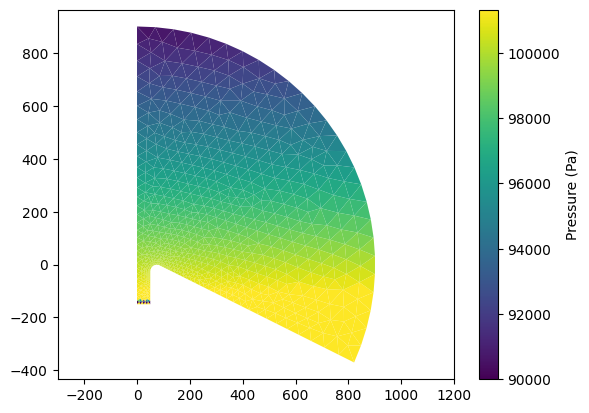

In [ ]:
fig = plt.figure()
ax = fig.axes

x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")

clims = (0.9e5, 1.01325e5)
mdtools.plot_mean(x, p, clims)

sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

Here's a useful tool for finding the element index corresponding to a point $(x,y)$

In [8]:
import matplotlib.tri as tri
triangulation = tri.Triangulation(solver2D.mesh.node_coords[...,0],
                  solver2D.mesh.node_coords[...,1], 
                  triangles=solver2D.mesh.elem_to_node_IDs)
trifinder = triangulation.get_trifinder()

def find_elem_ID(x, y):
  ''' Returns element ID corresponding to given x and y. '''
  return trifinder(x, y)


And finally, using the element index to evaluate the pressure at a certain point:

In [9]:
# Set some point where we want to evaluate pressure
x_target = 500.0
y_target = 0.0

# Find the element ID
elem_ID = find_elem_ID(x_target, y_target)
# Coordinates corresponding to the three nodes in the relevant triangle
x_node_elem = solver2D.mesh.node_coords[solver2D.mesh.elem_to_node_IDs[elem_ID,:], :]

U = solver2D.state_coeffs

# Evaluate state_coeff at the exact point (x_target, y_target)
U_target = np.array([tri.CubicTriInterpolator(
    tri.Triangulation(x_node_elem[:,0],x_node_elem[:,1]), # Create local triangulation using x, y of relevant triangle
    U[elem_ID, :, i])(x_target,y_target) for i in range(U.shape[-1])])
# Pad U_target to the right shape for physics.compute_variable
U_target = U_target[np.newaxis, np.newaxis, :]
# Compute pressure using the state vector
p_target = solver2D.physics.compute_variable("Pressure", U_target)
p_target

array([[[100166.14118068691]]])

Note that if the specified x or y is not in the domain, something illegal is returned (e.g., nan)